### GAN Generator & Discriminator operational testing

1. GAN обучается воспроизводить реальные данные. Предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. 

TODO: 

 * Сохранить структуру
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Добавить графики
 
2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. 
Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.




In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cuda:0"
# device = "cpu"
device

device(type='cuda', index=0)

In [3]:
lr = 0.0002

b1 = 0.5
b2 = 0.999

BATCH_SIZE = 256
DATA_SIZE = BATCH_SIZE * 300

MIN_X = -5
MAX_X = 5

hidden_dim = 30

# noise random uniform min and max values
noise_min = -0.5
noise_max = 0.5

n_epochs = 500

In [6]:
x = np.linspace(MIN_X, MAX_X, 3500)
y = lambda x: ((np.sin(x)/x) - (x/10))

<function matplotlib.pyplot.show(*args, **kw)>

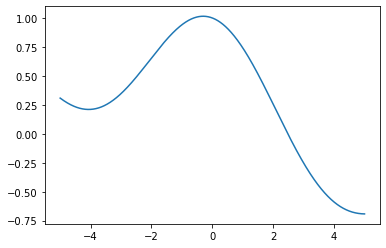

In [9]:
plt.plot(x, y(x))
plt.show

### Генерация обучающих данных

In [10]:
x_train = np.linspace(MIN_X, MAX_X, 100500)
np.random.shuffle(x_train)
x_train = x_train[:DATA_SIZE]
y_train = y(x_train)

In [11]:
train_data = np.array([[x_train[i], y_train[i]] for i in range(x_train.shape[0])])
train_data[:10]

array([[-1.17399178,  0.90301001],
       [ 3.082966  , -0.28929118],
       [-1.23926606,  0.88691479],
       [ 2.89808854, -0.20661442],
       [-2.39370541,  0.52348711],
       [ 0.41667081,  0.92964731],
       [ 3.33640136, -0.39166039],
       [ 1.36812307,  0.57915543],
       [ 0.33348591,  0.94821873],
       [ 0.96453696,  0.75554597]])

In [12]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=12)
# next(iter(trainloader))

In [15]:

samples_cnt_data = trainloader.dataset.data.shape[0]
samples_cnt_data

76800

In [16]:
batches_cnt_data = math.ceil(samples_cnt_data / BATCH_SIZE)
batches_cnt_data

300

### Генератор

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(hidden_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [18]:
gen_model = Generator().double().to(device)

In [19]:
gen_model.eval()

x = Variable(torch.from_numpy(np.random.uniform(MIN_X, MAX_X, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)

with torch.no_grad():
    test_pred = gen_model(x)

gen_model.train()

Generator(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [20]:
test_pred = test_pred.cpu().detach().numpy()

In [21]:
p = test_pred[:,0].argsort()

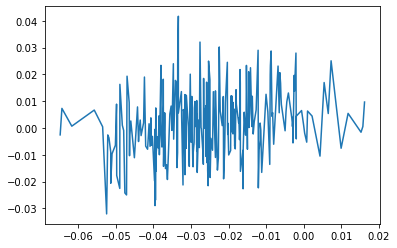

In [22]:
plt.plot(test_pred[:,0][p], test_pred[:, 1][p])
plt.show()

In [23]:
# np.random.uniform(-100, 100, (100, hidden_dim))

In [24]:
# test_pred[:,0][p]

In [25]:
# test_pred[:,1][p]

In [26]:
# Тестирование с изменением слоев

class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.05, 0.05) 
        nn.init.uniform_(self.bias, -0.05, 0.05)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [27]:
# Тест настройки парамтеров дескриминатора

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
        

    def forward(self, coords):
        coords_flat = coords.view(coords.size(0), -1)
        validity = self.model(coords_flat)

        return validity

In [28]:
discriminator_model = Discriminator().to(device)

#### Сгенерируем предсказание на необученном дискриминаторе. Тоже прост по приколу)

In [29]:
discriminator_model.eval()

# x = Variable(torch.from_numpy(test_pred.astype(np.float64))).double().to(device)
x = Variable(torch.from_numpy(test_pred)).to(device)

with torch.no_grad():
    test_pred2 = discriminator_model(x.float())

discriminator_model.train()

test_pred2 = test_pred2.cpu().detach().numpy()
test_pred2[:10]

array([[0.50908965],
       [0.5090924 ],
       [0.5090737 ],
       [0.5091371 ],
       [0.5090711 ],
       [0.5090749 ],
       [0.5091025 ],
       [0.5091339 ],
       [0.5090581 ],
       [0.50905126]], dtype=float32)

### Тренировка

In [30]:
optimizer_G = torch.optim.Adam(gen_model.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

[Epoch 500/500] [D loss: 0.692015] [G loss: 0.695569]


<Figure size 432x288 with 0 Axes>

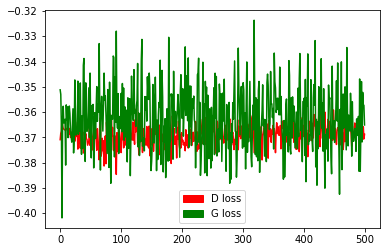

Wall time: 2h 12min 14s


In [31]:
%%time

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    
    generator_epoch_loss = 0.0
    discriminator_epoch_loss = 0.0
    
    for i, data in enumerate(trainloader):
#         print(i, data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(
            torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0),requires_grad=False).to(device)
        fake = Variable(
            torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0), requires_grad=False).to(device)
        real_coords = Variable(
            data.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################
        
        optimizer_G.zero_grad()

        z = Variable(
            torch.from_numpy(
                np.random.uniform(
                    noise_min, noise_max, (BATCH_SIZE, hidden_dim)
                ).astype(np.float64)
            ).double()
        ).to(device)

        gen_coords = gen_model(z)

        validity = discriminator_model(gen_coords.float())
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        generator_epoch_loss += g_loss.item()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator_model(real_coords.float())
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator_model(gen_coords.detach().float())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        discriminator_epoch_loss += d_loss.item()

######## Отображение процесса обучения и вывод функций потерь ############
        if (i+1) % batches_cnt_data == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"
                  % (epoch+1, n_epochs,
                     discriminator_epoch_loss / batches_cnt_data,
                     generator_epoch_loss / batches_cnt_data)
                 )
            display.display(plt.gcf())
            
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()


#### Тест модели на всем диапазоне реальных данных
За 500 эпох модель научилась достаточно хорошо имитировать данные математической зависимости

In [32]:
gen_model.eval()

xx = Variable(
        torch.from_numpy(
            np.random.uniform(
                noise_min, noise_max, (BATCH_SIZE, hidden_dim)
            ).astype(np.float64)
        ).double()
    ).to(device)

with torch.no_grad():
    test_pred = gen_model(xx)

gen_model.train()

test_pred = test_pred.cpu().detach().numpy()

In [33]:

count = 0
error = 0.0
for i in range(len(test_pred)):
    xxx = test_pred[i][0]
    y_pred = test_pred[i][1]
    y_real = y(xxx)
    print("X: %.10f;\t" % xxx, "y_pred: %.10f;\t\t" % y_pred, "y_real: %.10f" % y_real)
    
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))

X: 3.0435543422;	 y_pred: -0.2823019499;		 y_real: -0.2721952273
X: -4.0542912817;	 y_pred: 0.2123889546;		 y_real: 0.2102884539
X: 1.5547676537;	 y_pred: 0.4749152590;		 y_real: 0.4876235340
X: -1.4625202925;	 y_pred: 0.8362067476;		 y_real: 0.8259990932
X: -4.1458443520;	 y_pred: 0.2120441670;		 y_real: 0.2110648375
X: 0.7375265732;	 y_pred: 0.8289579250;		 y_real: 0.8380237144
X: 4.2242668349;	 y_pred: -0.6332970570;		 y_real: -0.6315079522
X: 2.3907575821;	 y_pred: 0.0341051375;		 y_real: 0.0462938417
X: -2.3984976510;	 y_pred: 0.5329035561;		 y_real: 0.5219306086
X: 1.6340229633;	 y_pred: 0.4345056295;		 y_real: 0.4473613737
X: -2.8347655322;	 y_pred: 0.3984351373;		 y_real: 0.3900234488
X: -3.9631031236;	 y_pred: 0.2153165457;		 y_real: 0.2115622886
X: -2.7695544041;	 y_pred: 0.4178770291;		 y_real: 0.4082094048
X: -1.5379907306;	 y_pred: 0.8129745843;		 y_real: 0.8036482073
X: 0.2741018871;	 y_pred: 0.9531573709;		 y_real: 0.9601147931
X: -0.3783756547;	 y_pred: 1.0129429941;		 

X: -1.4080690483;	 y_pred: 0.8511549027;		 y_real: 0.8416170735
X: -4.8569821143;	 y_pred: 0.2795149370;		 y_real: 0.2819575779
X: -4.2879170730;	 y_pred: 0.2161692402;		 y_real: 0.2162744562
X: -0.9605718783;	 y_pred: 0.9552467723;		 y_real: 0.9492150165
X: 2.5820403834;	 y_pred: -0.0646070302;		 y_real: -0.0526275467
X: -4.9908140130;	 y_pred: 0.3023101724;		 y_real: 0.3064295624

Total mean error: 0.0070110698


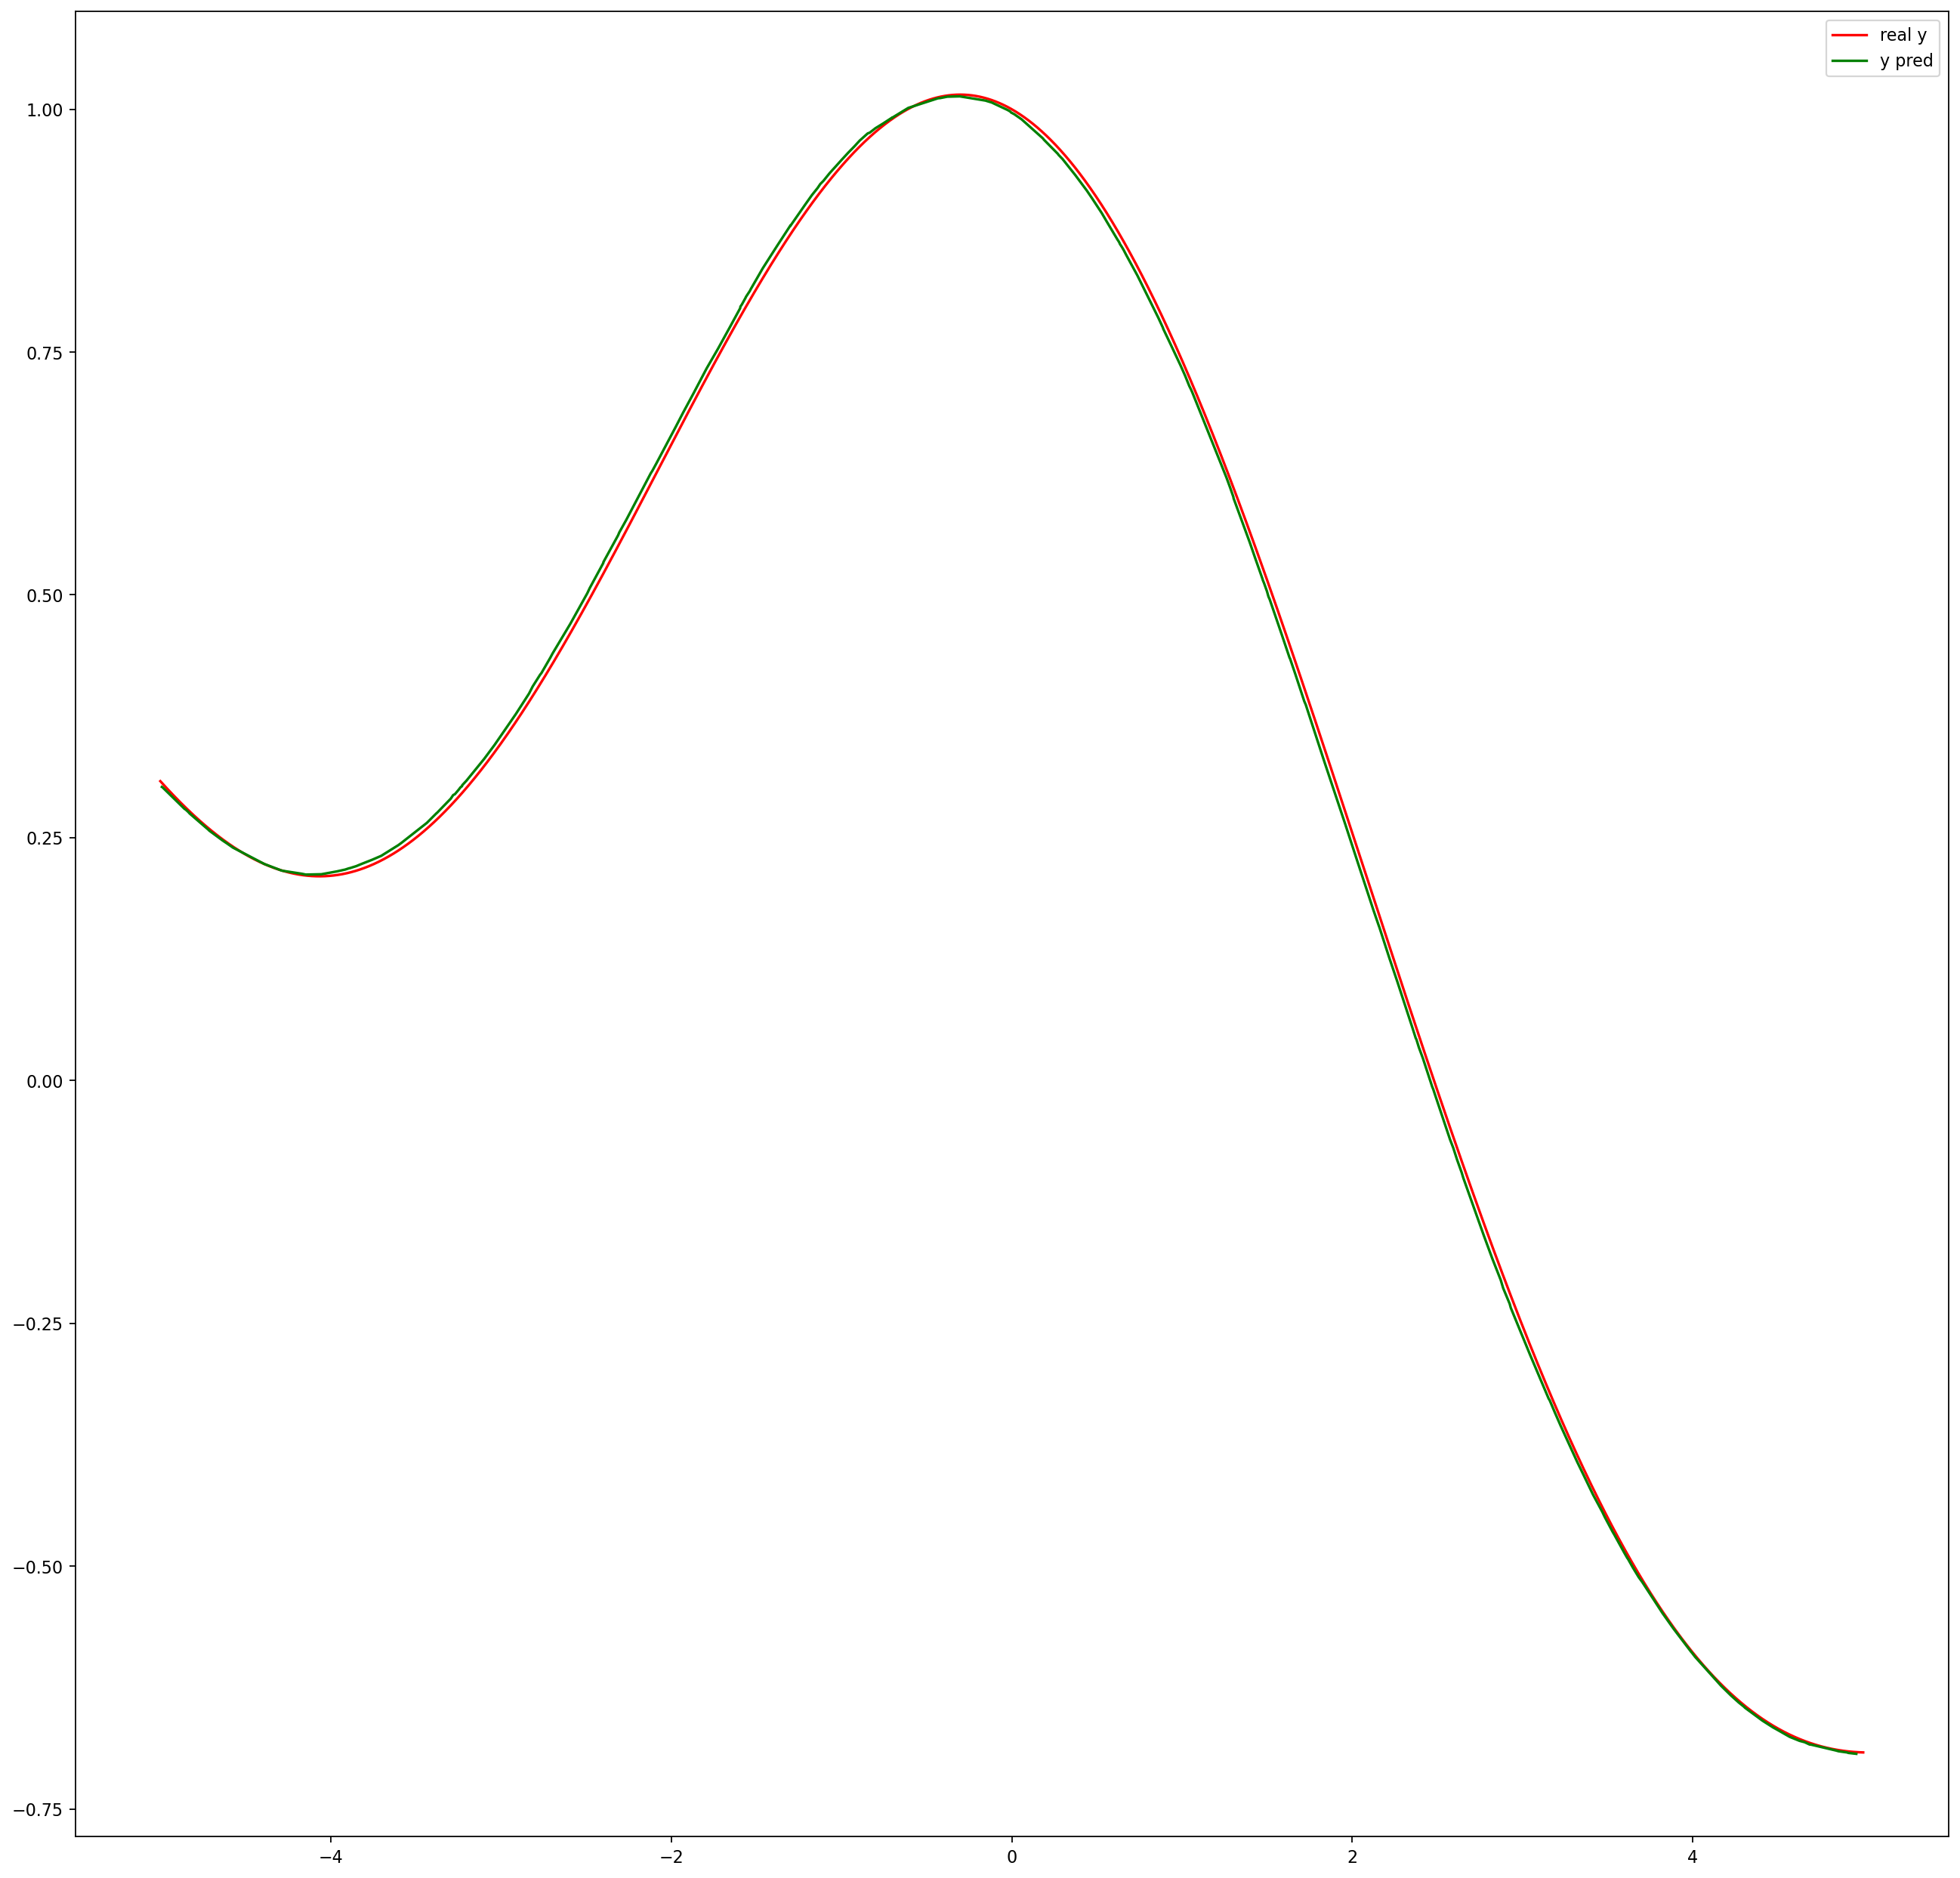

In [34]:
figure(num=None, figsize=(20, 20), dpi=160)

real_x = np.linspace(MIN_X, MAX_X, 3500)
plt.plot(real_x, y(real_x), label='real y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')

plt.legend()
plt.show()